## Setup and Load Data

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)


In [2]:
import tensorflow as tf 
import os 
from matplotlib import pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


In [3]:
# avoid OOM error by limiting GPU memory consumption 
gpus = tf. config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

### Load Data

dataset from kaggle: https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images/data

In [4]:
 #   for tf dataset pipeline documentation run this code, otherwise skip it 
 tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
@six.add_metaclass(abc.ABCMeta)
class DatasetV2(collections_abc.Iterable, tracking_base.Trackable,
                composite_tensor.CompositeTensor):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Ten

In [5]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export('keras.utils.image_dataset_from_directory',
              'keras.preprocessing.image_dataset_from_directory',
              v1=[])
def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
               

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 13853 files belonging to 22 classes.


In [7]:
class_names= data.class_names
num_classes = len( class_names)

In [8]:
data_iterator = data.as_numpy_iterator() 
data_iterator

In [9]:
# images represented as numpy arrays in batches of 32 images (check documentation )
batch = data_iterator.next() 

In [10]:
#labels 
batch[1]

array([20,  9,  4,  6, 12, 12,  3, 18, 12, 12,  8,  9, 15, 10,  8, 19,  6,
       12, 21,  0, 18, 12, 15, 19,  1,  7, 18, 14, 13,  6,  2,  8])

In [11]:
#number of batches 
len(data)

433

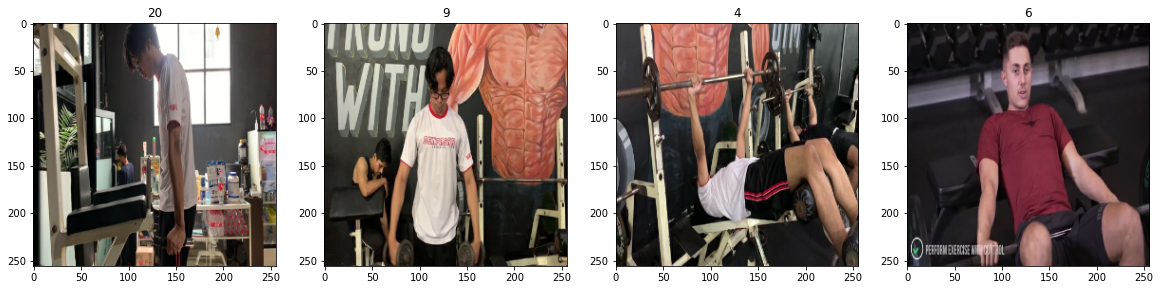

In [12]:
#check the some images of the batch with their respective class

fig, ax = plt.subplots(ncols=4, figsize = (20, 20))

for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocess data

#### scale data

In [13]:
scale_data = data.map(lambda x,y: (x/255, y))

scaled_iterator = scale_data.as_numpy_iterator()

batch = scaled_iterator.next()

#### split data

In [14]:
len(scale_data)

433

In [15]:
# 70 % for training , 20% for validation and 10% for testing 

train_size = int(len(scale_data)* .7)

val_size = int(len(scale_data)* .2)

test_size = int(len(scale_data)* .1) + 1

In [16]:
train = scale_data.take(train_size)

val = scale_data.skip(train_size).take(val_size)

test = scale_data.skip(train_size + val_size).take(test_size)

## Deep Learning 


#### Build Deep Learnig Model

In [17]:
#model dependencies 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [18]:
model = Sequential()

####  Basic/first Arquitecture

Para el primer modelo de CNN que probamos nos basamos en lo que hay en la documentacion de keras y tensorflow para hacer la prueba control, para esto generamos un modelo secuencial teniendo: 


  - <b> input Layer: </b> la primera capa convolucional que recibe imágenes con una forma de 256x256 píxeles con 3 canales de color (RGB). Utiliza 16 filtros de tamaño 3x3 con un paso (stride) de 1 y la función de activación ReLU, después de la primera capa convolucional tenemos la primera capa de MaxPooling, esta capa reduce la dimensión espacial (ancho y alto) de la entrada a la mitad.


  - <b> bloques convolutivos: </b> Una segunda capa convolucional con 32 filtros. La entrada a esta capa es la salida de la capa de agrupamiento anterior, seguida de otra capa de MaxPooling, luego una tercera capa convolucional con 16 filtros que tambien sigue el parton de las capas anteriores seguida a su vez por otra capa de MaxPooling.


  - <b> Aplanamiento: </b> Esta capa convierte el mapa de características 3D resultante de las capas convolutivas y de MaxPooling en un vector de una sola dimension. 

  - <b> Capas Densa: </b> Una capa densa con 256 neuronas y función de activación ReLU.


  - <b> Output Layer: </b>  La última capa densa tiene un número de neuronas igual al número de clases que se quieren predecir (22 en nuestro caso). Utiliza la función de activación softmax, la cual es común para problemas de clasificación multiclase, ya que los valores de salida representarán las probabilidades de cada clase.

In [19]:
#convolution blocks 
#input layer
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

In [20]:
model.compile('adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

###

### vizualizacion de la arquitectura del modelo

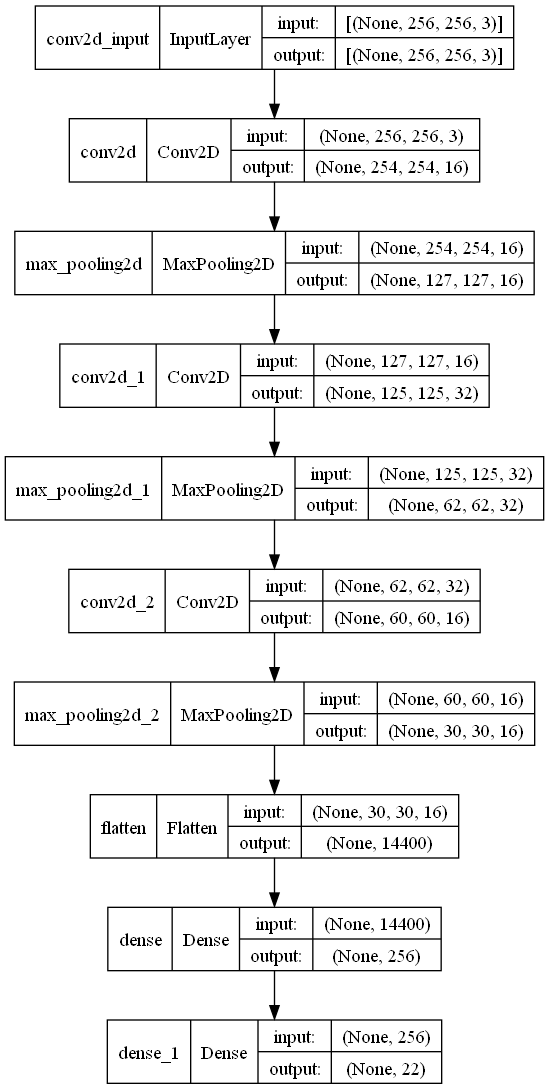

In [28]:
from tensorflow.keras.utils import plot_model

# Visualiza la arquitectura del modelo
directory = 'model architecture'
if not os.path.exists(directory):
    os.makedirs(directory)

plot_model(model, to_file=f'{directory}/controlModel.png', show_shapes=True)

# Este código guardará la imagen del modelo en el sistema de archivos

## Training the model

In [29]:
logDir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir)

In [30]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
303/303 [==============================] - 22s 58ms/step - loss: 1.1036 - accuracy: 0.7216 - val_loss: 0.3496 - val_accuracy: 0.9295
Epoch 2/20
303/303 [==============================] - 17s 57ms/step - loss: 0.1608 - accuracy: 0.9641 - val_loss: 0.3418 - val_accuracy: 0.9273
Epoch 3/20
303/303 [==============================] - 18s 58ms/step - loss: 0.0322 - accuracy: 0.9919 - val_loss: 0.2763 - val_accuracy: 0.9564
Epoch 4/20
303/303 [==============================] - 19s 63ms/step - loss: 0.0378 - accuracy: 0.9917 - val_loss: 0.3515 - val_accuracy: 0.9524
Epoch 5/20
303/303 [==============================] - 18s 58ms/step - loss: 0.0326 - accuracy: 0.9919 - val_loss: 0.3671 - val_accuracy: 0.9430
Epoch 6/20
303/303 [==============================] - 17s 54ms/step - loss: 0.0173 - accuracy: 0.9953 - val_loss: 0.3887 - val_accuracy: 0.9542
Epoch 7/20
303/303 [==============================] - 19s 62ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.3988 - val_accuracy:

### Cruvas de aprendisaje 

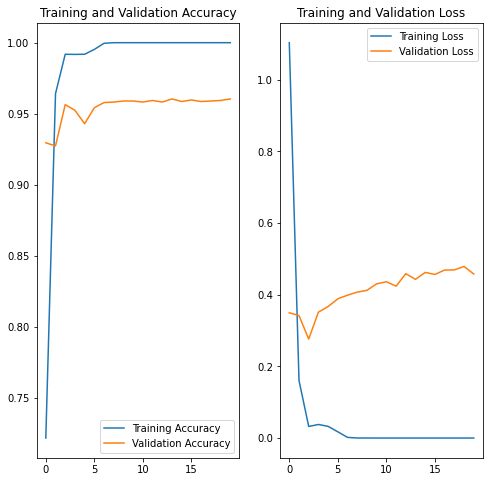

In [31]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Resultados 

In [35]:
from sklearn.metrics import classification_report
# predicciones en el conjunto de datos de prueba

test_images, test_labels = next(test.as_numpy_iterator())
predicted_classes = np.argmax(model.predict(test_images), axis=1)

# Obtén las etiquetas únicas de las clases reales y predichas
unique_labels = np.unique(np.concatenate((test_labels, predicted_classes)))

# Filtra class_names para incluir solo las clases presentes en test_labels
filtered_class_names = [class_names[i] for i in unique_labels]

# Calcular métricas de clasificación
report = classification_report(test_labels, predicted_classes, labels=unique_labels, target_names=filtered_class_names)
print(report)


                     precision    recall  f1-score   support

barbell biceps curl       1.00      1.00      1.00         1
        bench press       1.00      1.00      1.00         3
  chest fly machine       0.00      0.00      0.00         1
           deadlift       1.00      1.00      1.00         1
decline bench press       1.00      1.00      1.00         1
         hip thrust       1.00      1.00      1.00         3
incline bench press       1.00      1.00      1.00         2
       lat pulldown       1.00      1.00      1.00         2
      leg extension       1.00      1.00      1.00         1
              plank       1.00      1.00      1.00         4
            pull up       1.00      1.00      1.00         2
            push up       1.00      1.00      1.00         2
  romanian deadlift       1.00      1.00      1.00         3
      russian twist       1.00      1.00      1.00         2
     shoulder press       1.00      1.00      1.00         2
          t bar row    

C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

### histogramas de activaciones y pesos 

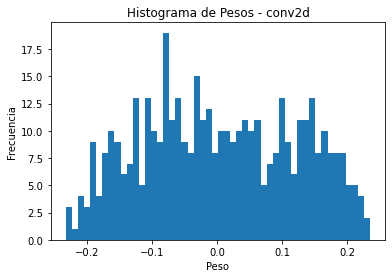

IndexError: list index out of range

In [36]:
for layer in model.layers:
    weights = layer.get_weights()
    plt.hist(weights[0].flatten(), bins=50)
    plt.title('Histograma de Pesos - ' + layer.name)
    plt.xlabel('Peso')
    plt.ylabel('Frecuencia')
    plt.show()

### filtros convolutivos

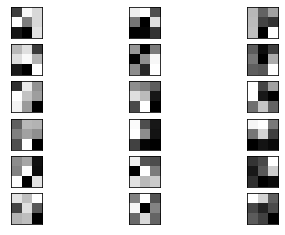

In [37]:
 # Para una capa convolucional específica
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)  # Normalizar los filtros

# Visualizar los filtros
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):  
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

### Visualización de las Características Aprendidas:

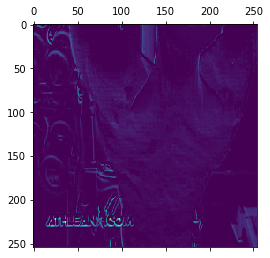

In [38]:
# Para visualizar las características de una capa específica
from tensorflow.keras.models import Model

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_images[0][None, ...])

# Visualiza las activaciones de la primera imagen del conjunto de prueba
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis') 

### Matriz de Confusion

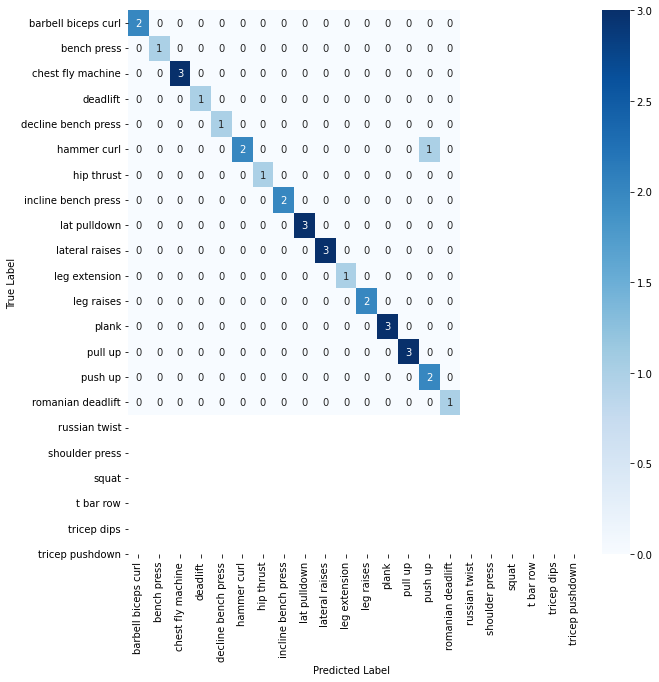

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_images, test_labels = next(test.as_numpy_iterator())
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

 calcula la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Cruva Roc y AUC 

In [41]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.preprocessing import label_binarize

# Binariza las etiquetas para la curva ROC multiclase
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
n_classes = test_labels_bin.shape[1]

# Calcula la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value